# Periodicity Metrics
This notebook aims to explore and compare a number of metrics that may be used to the strength of the 3 nucleotide periodicity expected from Ribo-Seq data. 

There are two classes of metric explored here. Those that look at the degree to which decoding centers of Ribo-Seq reads map to the coding reading frame and those that look at the frequency of the Ribo-Seq signal.

## Setup

Install required packages

In [1]:
!pip uninstall RiboMetric -y
!pip install git+https://github.com/JackCurragh/RiboMetric.git -q 
!pip install plotly pandas numpy scikit-learn -q

Found existing installation: RiboMetric 0.1.9
Uninstalling RiboMetric-0.1.9:
  Successfully uninstalled RiboMetric-0.1.9


Import required packages

In [2]:
from RiboMetric.metrics import (
    fourier_transform,
    multitaper,
    read_frame_information_content,
    periodicity_dominance,
    periodicity_autocorrelation,
    
    )

from RiboMetric.modules import (
    read_frame_score_trips_viz
)

import plotly.graph_objects as go
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler


In [3]:
!pip install multitaper

In [4]:

import numpy as np
import numpy as np
import multitaper.mtspec as spec


## Simulate Inputs 
Generate inputs for each metric for an array of different periodicity strengths. Signal based metric work off a metagene and the frame metrics work off a read frame dictionary that counts the number of P sites in each frame of each CDS relative to the start codon (initiation codon is always frame 0). Read frame dictionary can be calculated from the metagene.

### Simulated Read Frame Dict

In [5]:
import itertools

def generate_read_frame_distribution_permutations():
    """
    Generate all possible permutations of read frame distributions that sum to 100.
    
    Args:
        None

    Returns:
        simulated_read_frame_proportions (dict): Dictionary containing all possible read frame distributions that sum to 100.
    """
    # Generate permutations
    numbers = range(1, 101)
    permutations = []
    for perm in itertools.permutations(numbers, 3):
        if sum(perm) == 100:
            permutations.append(perm)

    # Simulate read frame proportions
    simulated_read_frame_proportions = {}
    for i, perm in enumerate(permutations):
        simulated_read_frame_proportions[i] = {0: perm[0], 1: perm[1], 2: perm[2]}

    return simulated_read_frame_proportions


### Simulated Metagene

In [6]:
import random

def generate_metagene(frame_ratios, start, stop, noise_factor=0.8, max_count=100):
    """
    Generate a metagene dictionary with varying degrees of periodicity based on frame ratios.
    
    Args:
        frame_ratios (dict): A dictionary representing the global ratio of reads per frame.
                             Keys are frame positions (0, 1, 2), and values are the corresponding ratios.
        start (int): The start position of the metagene.
        stop (int): The stop position of the metagene.
    
    Returns:
        dict: A dictionary representing the metagene, where keys are positions and values are counts.
    """
    metagene = {}
    
    # Initialize all positions with a small constant value
    for pos in range(start, stop):
        metagene[pos] = 1
    
    # Adjust counts based on frame ratios
    for pos in range(start, stop):
        frame = (pos - start) % 3
        metagene[pos] += int(frame_ratios[frame] * max_count)
    
    # Introduce some random noise
    for pos in range(start, stop):
        metagene[pos] += int(random.uniform(0, noise_factor * max_count))
    
    return metagene


In [7]:
start = 10
stop = 110
frame_ratios = {0: 0.98, 1: 0.01, 2: 0.01}  # High periodicity
metagene = generate_metagene(frame_ratios, start, stop)

# Get the positions and counts from the metagene dictionary
positions = list(metagene.keys())
counts = list(metagene.values())

# Create the bar plot
fig = go.Figure(data=go.Bar(x=positions, y=counts))

# Set the axis labels
fig.update_layout(xaxis_title='Position', yaxis_title='Count', title='Periodic Metagene')

# Show the plot
fig.show()


In [8]:
frame_ratios = {0: 0.98, 1: 0.01, 2: 0.01}  # High periodicity

def approximate_translation(observed: tuple, metagene: tuple):
    f1 = (observed[0] * metagene[0]) + (observed[2] * metagene[1]) + (observed[1] * metagene[2])
    f2 = (observed[0] * metagene[1]) + (observed[1] * metagene[0]) + (observed[2] * metagene[2])
    f3 = (observed[0] * metagene[2]) + (observed[1] * metagene[1]) + (observed[2] * metagene[0])
    return (f1, f2, f3)

posiions = [i for i in range(1, max(metagene.keys()))]
values = []
for i in range (1, max(metagene.keys()), 3):
    f1_counts = metagene[i] if i in metagene else 0
    f2_counts = metagene[i + 1] if i + 1 in metagene else 0
    f3_counts = metagene[i + 2] if i + 2 in metagene else 0
    total = sum([f1_counts, f2_counts, f3_counts]) if sum([f1_counts, f2_counts, f3_counts]) > 0 else 1
    observed = (f1_counts / total, f2_counts / total, f3_counts / total)
    for j in approximate_translation(observed, tuple(frame_ratios.values())):
        values.append(j)

# Create the bar plot
fig = go.Figure(data=go.Bar(x=positions, y=values))

# Set the axis labels
fig.update_layout(xaxis_title='Position', yaxis_title='Count', title='Metagene with no periodicity')

# Show the plot
fig.show()

In [9]:

frame_ratios = {0: 0.33, 1: 0.33, 2: 0.33}  # No periodicity
metagene = generate_metagene(frame_ratios, start, stop, noise_factor=0)

# Get the positions and counts from the metagene dictionary
positions = list(metagene.keys())
counts = list(metagene.values())

# Create the bar plot
fig = go.Figure(data=go.Bar(x=positions, y=counts))

# Set the axis labels
fig.update_layout(xaxis_title='Position', yaxis_title='Count', title='Metagene with no periodicity')

# Show the plot
fig.show()

Simulate range of metagenes using permutations

In [10]:
start = 10
stop = 110
simulated_metagenes = {'start':{}, 'stop':{}}
simulated_metagenes['start'] = {
    i: generate_metagene(frame_ratios, start, stop) for i, frame_ratios in generate_read_frame_distribution_permutations().items()
}

Get read frame distribution for each metagene to ensure comparisons are of same data. Otherwise it may differ due to the introduced noise factor

In [11]:
simulated_read_frame_dict = {}
for i, metagene in simulated_metagenes['start'].items():
    metagene_total = sum(metagene.values())
    simulated_read_frame_dict[i] = {
        0: round(sum([metagene[pos] for pos in metagene if pos % 3 == 0])/metagene_total, 4),
        1: round(sum([metagene[pos] for pos in metagene if pos % 3 == 1])/metagene_total, 4),
        2: round(sum([metagene[pos] for pos in metagene if pos % 3 == 2])/metagene_total, 4),
    }
    

## Metrics on Simulated data


In [12]:
!pip install pywavelets

In [13]:
def counts_to_codon_proportions(counts: list) -> list:
    """
    Convert a list of counts to proportions of codon.
    Codons are windows of 3 nucleotides and there is no overlap between windows

    Inputs:
        counts: list
            A list of counts for each position

    Returns:
        dict: A dictionary where keys represent positions,
        and values represent codon proportions.
    """
    codon_proportions = []
    for i in range(0, len(counts), 3):
        codon_counts = counts[i:i+3]
        total_count = sum(codon_counts)
        for count in codon_counts:
            if total_count != 0:
                codon_proportions.append(count / total_count)
            else:
                codon_proportions.append(0)
    return codon_proportions

import pywt

def wavelet_transform(metagene_profile, read_lengths=[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], wavelet='db4'):
    """
    Calculate the discrete wavelet transform of the metagene profile.

    Inputs:
        metagene_profile: dict
            The metagene profile to compute the wavelet transform of.
        read_lengths: list, optional
            The read lengths to consider.
        wavelet: str, optional
            The wavelet family to use for the DWT.

    Returns:
        wavelet_scores: dict
            The wavelet transform scores for each read length.
    """
    wavelet_scores = {}
    global_counts = []

    for read_len in read_lengths:
        if not global_counts:
            global_counts = list(metagene_profile['start'][read_len].values())
        else:
            global_counts = [i + j for i, j in zip(global_counts, list(metagene_profile['start'][read_len].values()))]

        counts = list(metagene_profile['start'][read_len].values())
        wavelet_coeffs = pywt.wavedec(counts, wavelet, mode='smooth')
        wavelet_scores[read_len] = np.sum(np.abs(wavelet_coeffs[-1])) / np.sum(np.abs(wavelet_coeffs[0]))

    global_wavelet_coeffs = pywt.wavedec(global_counts, wavelet, mode='smooth')
    wavelet_scores["global"] = np.sum(np.abs(global_wavelet_coeffs[-1])) / np.sum(np.abs(global_wavelet_coeffs[0]))

    return wavelet_scores

In [14]:
def denoise_and_convert_to_pf_p_sites(signal, wavelet='sym4', frequency_band=(0.2, 0.5), target_frequency_range=(0.328125, 0.34375)):
    # Perform DWPT
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric')
    
    # Get nodes corresponding to the frequency band of interest
    nodes = [node for node in wp.get_level(wp.maxlevel, 'freq') if node.path.count('/') == 2]

    # Get coefficients within the target frequency range
    target_coefficients = []
    for node in nodes:
        # Calculate frequency based on the node's path
        node_frequency = 2 ** (wp.maxlevel - node.level) / len(signal)
        if node_frequency >= target_frequency_range[0] and node_frequency <= target_frequency_range[1]:
            target_coefficients.extend(node.data)

    # Denoise by eliminating signals with 3-nt frequency's coefficient lower than others
    denoised_coefficients = []
    for i, coeff in enumerate(target_coefficients):
        if all(coeff > other_coeff for j, other_coeff in enumerate(target_coefficients) if j != i):
            denoised_coefficients.append(coeff)

    # Convert to PF P-sites
    pf_p_sites = [index for index, coeff in enumerate(target_coefficients) if coeff in denoised_coefficients]

    return pf_p_sites

# Example usage:
signal = np.random.rand(1000)  # Example signal (replace with your actual signal)
pf_p_sites = denoise_and_convert_to_pf_p_sites(signal)
print("PF P-sites:", pf_p_sites)


PF P-sites: []


In [15]:
def wavelet_decomposition(metagene_profiles, read_lengths=[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], wavelet='db4', levels=3, target_frequency=0.33):
    """
    Plots the wavelet decomposition of a metagene profile for a given read length.

    Args:
        metagene_profile (dict): The metagene profile dictionary.
        read_length (int): The read length to decompose.
        wavelet (str, optional): The wavelet family to use for the DWT. Default is 'db4'.
        levels (int, optional): The number of levels to decompose the signal. Default is 5.

    Returns:
        None
    """
    wavelet_scores = {}
    global_counts = []

    for read_length in read_lengths:
        if not global_counts:
            global_counts = list(metagene_profiles['start'][read_length].values())
        else:
            global_counts = [i + j for i, j in zip(global_counts, list(metagene_profiles['start'][read_length].values()))]

        signal_data = np.array(list((metagene_profiles['start'][read_length].values())))

        # Compute wavelet decomposition
        coeffs = pywt.wavedec(signal_data, wavelet, mode='smooth', level=levels)

        power_spectrum = signal.welch(coeffs[-1], fs=1.0, nperseg=256)  # Power spectrum of Level 4 coefficients
        total_power = np.sum(power_spectrum)

        # Find indices of frequency closest to the target frequency
        target_idx = np.argmin(np.abs(power_spectrum[0] - target_frequency))

        # Calculate score as the amplitude of the peak at the target frequency
        score = power_spectrum[1][target_idx]
        wavelet_scores[read_length] = 1 - (score / total_power)

    signal_data = np.array(global_counts)

    # Compute wavelet decomposition
    coeffs = pywt.wavedec(signal_data, wavelet, mode='smooth', level=levels)

    power_spectrum = signal_data.welch(coeffs[-1], fs=1.0, nperseg=256)  # Power spectrum of Level 4 coefficients
    total_power = np.sum(power_spectrum)

    # Find indices of frequency closest to the target frequency
    target_idx = np.argmin(np.abs(power_spectrum[0] - target_frequency))

    # Calculate score as the amplitude of the peak at the target frequency
    score = power_spectrum[1][target_idx]
    # wavelet_scores['global'] = 1 - (score / total_power)
    return wavelet_scores



In [16]:
def dominance_score(simulated_metagenes):
    metagene_dominance_scores = {}
    for read_len in simulated_metagenes['start']:
        frame_1_counts = sum([count for i, count in enumerate(simulated_metagenes['start'][read_len].values()) if i % 3 == 0])
        frame_2_counts = sum([count for i, count in enumerate(simulated_metagenes['start'][read_len].values()) if i % 3 == 1])
        frame_3_counts = sum([count for i, count in enumerate(simulated_metagenes['start'][read_len].values()) if i % 3 == 2])
        total_counts = sum(simulated_metagenes['start'][read_len].values())

        dominance_score = max(frame_1_counts, frame_2_counts, frame_3_counts) / total_counts
        metagene_dominance_scores[read_len] = dominance_score
    
    return metagene_dominance_scores



In [17]:

metagene_dominance_scores = dominance_score(simulated_metagenes)

# Sort metagenes by dominance score
sorted_metagenes = dict(sorted(metagene_dominance_scores.items(), key=lambda item: item[1]))

# Plot the metagenes with the highest and lowest dominance scores
lowest_dominance_metagene = list(sorted_metagenes.keys())[0]
low_mid_dominance_metagene = list(sorted_metagenes.keys())[int(len(sorted_metagenes)/4)]
high_mid_dominance_metagene = list(sorted_metagenes.keys())[int(len(sorted_metagenes)*3/4)]
mid_mid_dominance_metagene = list(sorted_metagenes.keys())[int(len(sorted_metagenes)/2)]
highest_dominance_metagene = list(sorted_metagenes.keys())[-1]

ordered_subset_metagenes = { 'start': {
    lowest_dominance_metagene: simulated_metagenes['start'][lowest_dominance_metagene],
    low_mid_dominance_metagene: simulated_metagenes['start'][low_mid_dominance_metagene],
    high_mid_dominance_metagene: simulated_metagenes['start'][high_mid_dominance_metagene],
    mid_mid_dominance_metagene: simulated_metagenes['start'][mid_mid_dominance_metagene],
    highest_dominance_metagene: simulated_metagenes['start'][highest_dominance_metagene]
}}


In [18]:
for read_len in ordered_subset_metagenes['start']:
    # Get the positions and counts from the metagene dictionary
    positions = list(ordered_subset_metagenes['start'][read_len].keys())
    counts = list(ordered_subset_metagenes['start'][read_len].values())

    # Create the bar plot
    fig = go.Figure(data=go.Bar(x=positions, y=counts))

    # Set the axis labels
    fig.update_layout(xaxis_title='Position', yaxis_title='Count', title=f'Metagene with dominance Rank:{metagene_dominance_scores[read_len]}')

    # Show the plot
    fig.show()

In [19]:
def autocorrelate_periodicity(signal, expected_period):
    """
    Calculate a periodicity score based on the autocorrelation function.

    Args:
        signal (numpy.ndarray): The ribo-seq signal or count data.
        expected_period (int): The expected period of the signal (e.g., 3 for codon reading frame).

    Returns:
        float: The periodicity score based on the autocorrelation function.
    """
    # Compute the autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Keep only the positive lags

    autocorr = [float(val) / float(autocorr[0]) for val in autocorr]

    # Find the peak corresponding to the expected period
    peak_idx = np.argmax(autocorr[expected_period:]) + expected_period

    # Calculate the periodicity score
    peak_value = autocorr[peak_idx]
    mean_autocorr = np.mean(autocorr[1:])  # Exclude the value at lag 0
    periodicity_score = (peak_value - mean_autocorr) / mean_autocorr
    return periodicity_score


def autocorrelate_periodicity_metric(metagene_profile: dict, lag: int) -> dict:
    """
    Computes the autocorrelation of the ribosome counts at a given lag.

    Parameters:
    -----------
    metagene_profile: dict
        The metagene profile to compute the autocorrelation of.

    lag: int
        The lag to compute the autocorrelation at.

    Returns:
    --------
    read_length_scores: dict
        The autocorrelation scores at the given lag.
    """
    read_length_scores = {}
    global_counts = []

    for read_length in metagene_profile:
        if not global_counts:
            global_counts = list(metagene_profile[read_length].values())
        else:
            global_counts = [
                i + j for i, j in zip(
                    global_counts,
                    list(metagene_profile[read_length].values())
                    )
                    ]
        count_list = np.array(list(metagene_profile[read_length].values()))
        if count_list[0] is not None:
            read_length_scores[read_length] = autocorrelate_periodicity(count_list, lag)
        else:
            read_length_scores[read_length] = 0
    read_length_scores['global'] = autocorrelate_periodicity(np.array(global_counts), lag)
    return read_length_scores


def autocorrelate_uniformity_metric(metagene_profile: dict) -> dict:
    """
    Computes the autocorrelation of the ribosome counts looking
    for uniformity in the signal. Done by computing the autocorrelation
    of the signal and taking the inverse of the mean autocorrelation.

    Parameters:
    -----------
    metagene_profile: dict
        The metagene profile to compute the autocorrelation of.

    lag: int
        The lag to compute the autocorrelation at.

    Returns:
    --------
    read_length_scores: dict
        The autocorrelation scores at the given lag.
    """
    read_length_scores = {}
    global_counts = []

    for read_length in metagene_profile:
        if not global_counts:
            global_counts = list(metagene_profile[read_length].values())
        else:
            global_counts = [
                i + j for i, j in zip(
                    global_counts,
                    list(metagene_profile[read_length].values())
                    )
                    ]
        count_list = np.array(list(metagene_profile[read_length].values()))
        if count_list[0] is not None:
            read_length_scores[read_length] = periodicity_autocorrelation(count_list)
        else:
            read_length_scores[read_length] = 0
    read_length_scores['global'] = periodicity_autocorrelation(np.array(global_counts))
    return read_length_scores


In [20]:
read_frame_dominance_simulated = periodicity_dominance(simulated_read_frame_dict)
read_frame_score_trips_viz_simulated = read_frame_score_trips_viz(simulated_read_frame_dict)
read_frame_information_content_simulated = read_frame_information_content(simulated_read_frame_dict)

fourier_transform_simulated = fourier_transform(simulated_metagenes, read_lengths=simulated_metagenes['start'].keys())
auto_periodicity_simulated = autocorrelate_periodicity_metric(simulated_metagenes['start'], 3)
# auto_uniformity_simulated = autocorrelate_uniformity_metric(simulated_metagenes['start'])


simulated_metrics = pd.DataFrame({
    'Simulated Read Frame Proportions 0': {i: simulated_read_frame_dict[i][0] for i in simulated_read_frame_dict},
    'Simulated Read Frame Proportions 1': {i: simulated_read_frame_dict[i][1] for i in simulated_read_frame_dict},
    'Simulated Read Frame Proportions 2': {i: simulated_read_frame_dict[i][2] for i in simulated_read_frame_dict},
    'Dominance': read_frame_dominance_simulated,
    'Trips Viz': read_frame_score_trips_viz_simulated,
    'Information Content': read_frame_information_content_simulated,
    'Fourier': fourier_transform_simulated,
    'Autocorrelation': auto_periodicity_simulated,
})

# split read frame information content into 2 columns. Score and Total count

simulated_metrics[['Information Content', 'Information Content Total Count']] = simulated_metrics['Information Content'].apply(pd.Series)


simulated_metrics = simulated_metrics.drop(columns=['Information Content Total Count'])

simulated_metrics.head()

Simulated Read Frame Proportions 0  Simulated Read Frame Proportions 1   
0                              0.9616                              0.0144  \
1                              0.9526                              0.0141   
2                              0.9426                              0.0146   
3                              0.9323                              0.0144   
4                              0.9226                              0.0140   

   Simulated Read Frame Proportions 2  Dominance  Trips Viz   
0                              0.0241   0.961504   0.974938  \
1                              0.0333   0.952600   0.965043   
2                              0.0428   0.942600   0.954594   
3                              0.0533   0.932300   0.942830   
4                              0.0634   0.922600   0.931281   

   Information Content   Fourier  Autocorrelation  
0             0.910134  0.643400         4.539668  
1             0.894469  0.636875         4.436795  
2             0.877693  0.629425         4.324605  
3             0.861794  0.621669         4.211966  
4             0.847804  0.614241         4.108768

In [21]:
example_metagenes = {
    "best": generate_metagene({0: 0.98, 1: 0.01, 2: 0.01}, 0, 30, noise_factor=0.1),
    "worst": generate_metagene({0: 0.45, 1: 0.45, 2: 0.1}, 0, 30, noise_factor=0.1),
    "random": generate_metagene({0: 0.33, 1: 0.33, 2: 0.34}, 0, 30, noise_factor=0.8)
}

print(example_metagenes['best'])

{0: 107, 1: 5, 2: 9, 3: 101, 4: 7, 5: 2, 6: 107, 7: 9, 8: 9, 9: 103, 10: 8, 11: 6, 12: 108, 13: 10, 14: 6, 15: 106, 16: 2, 17: 5, 18: 105, 19: 3, 20: 10, 21: 105, 22: 11, 23: 7, 24: 105, 25: 6, 26: 3, 27: 108, 28: 3, 29: 11}


In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
y = 1.1
# Create a figure with three subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=('Best', 'Middle', 'Worst'), vertical_spacing=0.2)

# Plot each metagene in a separate subplot
for i, (metagene_name, metagene) in enumerate(example_metagenes.items(), start=1):
    read_frame_dict = {0: 0, 1: 0, 2: 0}
    for pos, count in metagene.items():
        frame = pos % 3
        read_frame_dict[frame] += count

    positions = list(metagene.keys())
    counts = list(metagene.values())
    trips_score = round(read_frame_score_trips_viz({1: read_frame_dict})[1], 2)
    fourier_score = round(fourier_transform({"start": {1: metagene}}, read_lengths=[1])[1], 2)
    info_score = round(read_frame_information_content({1: read_frame_dict})[1][0], 2)
    dominance_score = round(periodicity_dominance({1: read_frame_dict})[1], 2)
    autocorelation_score = round(periodicity_autocorrelation({"start": {1: metagene}}, 3)[1], 2)

    # get where scores rank in simulated metrics
    trips_scores = simulated_metrics['Trips Viz']
    fourier_scores = simulated_metrics['Fourier']
    info_scores = simulated_metrics['Information Content']
    dominance_scores = simulated_metrics['Dominance']
    autocorrelation_scores = simulated_metrics['Autocorrelation']

    trips_rank = trips_scores[trips_scores > trips_score].count()
    fourier_rank = fourier_scores[fourier_scores > fourier_score].count()
    info_rank = info_scores[info_scores > info_score].count() 
    dominance_rank = dominance_scores[dominance_scores > dominance_score].count()
    autocorrelation_rank = autocorrelation_scores[autocorrelation_scores > autocorelation_score].count() 

    print(f"""
        Trips Rank: {trips_rank}/{trips_scores.count()}
        Fourier Score: {fourier_rank}/{fourier_scores.count()}
        Info Score: {info_rank}/{info_scores.count()}
        Dominance Score: {dominance_rank}/{dominance_scores.count()}
        Autocorrelation Score: {autocorrelation_rank}/{autocorrelation_scores.count()}
        """)

    trace = go.Bar(x=positions, y=counts)
    fig.add_trace(trace, row=1, col=i)
    y += 1.1
    # Add annotations for the scores
    # fig.add_annotation(
    #     x=0, y=y, text=f"""
    #     Trips Rank: {trips_rank}/{trips_scores.count()}
    #     Fourier Score: {fourier_rank}/{fourier_scores.count()}
    #     Info Score: {info_rank}/{info_scores.count()}
    #     Dominance Score: {dominance_rank}/{dominance_scores.count()}
    #     Autocorrelation Score: {autocorrelation_rank}/{autocorrelation_scores.count()}
    #     """, xref="paper", yref="paper", xanchor="left", yanchor="top", row=1, col=i
    # )


# Set the axis labels
fig.update_xaxes(title_text='Position')
fig.update_yaxes(title_text='Count')

# Set the overall title
fig.update_layout(title='Periodic Metagenes', height=600)

# Write plot to file
fig.show()


        Trips Rank: 56/4705
        Fourier Score: 125/4705
        Info Score: 142/4704
        Dominance Score: 120/4705
        Autocorrelation Score: 4705/4705
        

        Trips Rank: 4554/4705
        Fourier Score: 3584/4705
        Info Score: 3519/4704
        Dominance Score: 4225/4705
        Autocorrelation Score: 4705/4705
        

        Trips Rank: 4674/4705
        Fourier Score: 4278/4705
        Info Score: 4702/4704
        Dominance Score: 4705/4705
        Autocorrelation Score: 4705/4705
        


In [23]:
import pandas as pd
import plotly.express as px

# Assuming your DataFrame is named 'df'

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(simulated_metrics[['Simulated Read Frame Proportions 0', 'Dominance', 'Trips Viz', 'Information Content', 'Fourier', 'Autocorrelation']]), columns=['Simulated Read Frame Proportions 0', 'Dominance', 'Trips Viz', 'Information Content', 'Fourier', 'Autocorrelation'])
column_names = df.columns.tolist()

# Find the columns you want to plot
metric_columns = ['Dominance', 'Trips Viz', 'Information Content', 'Fourier', 'Autocorrelation'] #, 'Auto Periodicity']

# Flatten the data and create a single column for the metric values
flattened_df = pd.melt(df, id_vars=['Simulated Read Frame Proportions 0'], value_vars=metric_columns, var_name='Metric', value_name='Score')

# Create the multipanel scatter plot
fig = px.scatter(flattened_df, x='Simulated Read Frame Proportions 0', y='Score', color='Metric', facet_row='Metric')

fig.update_layout(
    xaxis_range=[0.33, 1],
    yaxis_range=[0, 1],
    )

# Customize the plot
fig.update_layout(
    xaxis_title='Simulated Read Frame Proportions',
    yaxis_title='Score',
    legend_title='Metric',
)

# Show the plot
fig.show()

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Get the metagenes with the highest and lowest reads in frame 0
best_metagene = simulated_metrics['Simulated Read Frame Proportions 0'].idxmax()
worst_metagene = simulated_metrics['Simulated Read Frame Proportions 0'].idxmin()
middle_metagene = simulated_metrics['Simulated Read Frame Proportions 0'].idxmax() // 2


# Create a dictionary of the metagenes to plot
metagenes = {
    'Best': simulated_metagenes['start'][best_metagene],
    'Middle': simulated_metagenes['start'][middle_metagene],
    'Worst': simulated_metagenes['start'][worst_metagene],
}

# Create a figure with three subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=('Best', 'Middle', 'Worst'))

# Plot each metagene in a separate subplot
for i, (metagene_name, metagene) in enumerate(metagenes.items(), start=1):
    positions = list(metagene.keys())
    counts = list(metagene.values())
    fig.add_trace(go.Bar(x=positions, y=counts), row=1, col=i)

# Set the axis labels
fig.update_xaxes(title_text='Position')
fig.update_yaxes(title_text='Count')

# Set the overall title
fig.update_layout(title='Periodic Metagenes')

# Show the plot
fig.show()

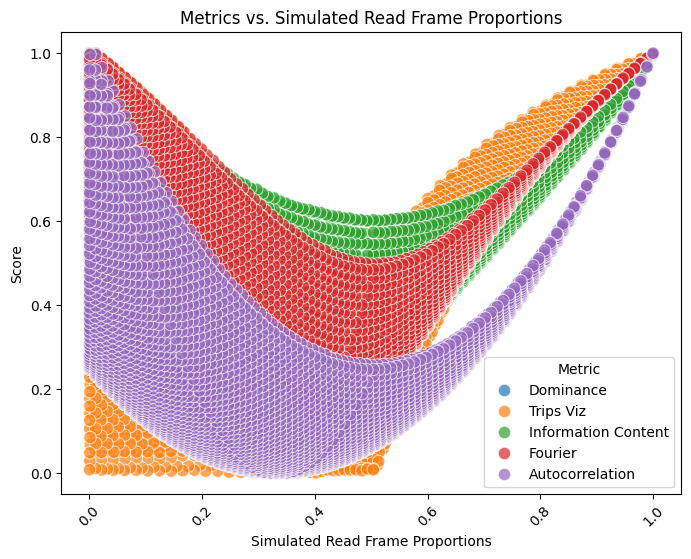

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Flatten the data and create a single column for the metric values
flattened_df = pd.melt(df, id_vars=['Simulated Read Frame Proportions 0'], value_vars=metric_columns, var_name='Metric', value_name='Score')

# Create the scatter plot
sns.scatterplot(data=flattened_df, x='Simulated Read Frame Proportions 0', y='Score', hue='Metric', alpha=0.7, s=80, ax=ax)

# Set labels and title
ax.set_ylabel('Score')
ax.set_xlabel('Simulated Read Frame Proportions')
ax.set_title('Metrics vs. Simulated Read Frame Proportions')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [26]:
import plotly.graph_objects as go

def plot_simulated_metrics(simulated_metrics, x_col_name="Read Frame Dominance", y_col_name='Read Frame Dominance'):
    
    fig = go.Figure()

    # Create three traces, one for each column
    text = [f'0: {row[0]}, 1: {row[1]}, 2: {row[2]}' for row in simulated_metrics[['Simulated Read Frame Proportions 0', 'Simulated Read Frame Proportions 1', 'Simulated Read Frame Proportions 2']].values]
    fig.add_trace(go.Scatter(x=simulated_metrics[x_col_name],
                                    y=simulated_metrics[y_col_name],
                                    mode='markers',
                                    name=x_col_name,
                                    text=text,))

        # Update the layout with axis titles
    fig.update_layout(
        title='Simulated Read Frame Proportions',
        xaxis_title=x_col_name,
        yaxis_title=y_col_name
    )

    fig.show()

In [27]:
# plot_simulated_metrics(simulated_metrics, 'Read Frame Dominance')
# plot_simulated_metrics(simulated_metrics, 'Auto Periodicity')
# plot_simulated_metrics(simulated_metrics, 'Read Frame Score Trips Viz')
# plot_simulated_metrics(simulated_metrics, 'Read Frame Information Content')
# plot_simulated_metrics(simulated_metrics, 'Fourier Transform')

In [28]:
# plot_simulated_metrics(simulated_metrics, 'Read Frame Dominance', 'Fourier Transform')
# plot_simulated_metrics(simulated_metrics, 'Read Frame Score Trips Viz', 'Fourier Transform')
# plot_simulated_metrics(simulated_metrics, 'Read Frame Information Content', 'Fourier Transform')
# plot_simulated_metrics(simulated_metrics, 'Fourier Transform', 'Fourier Transform')

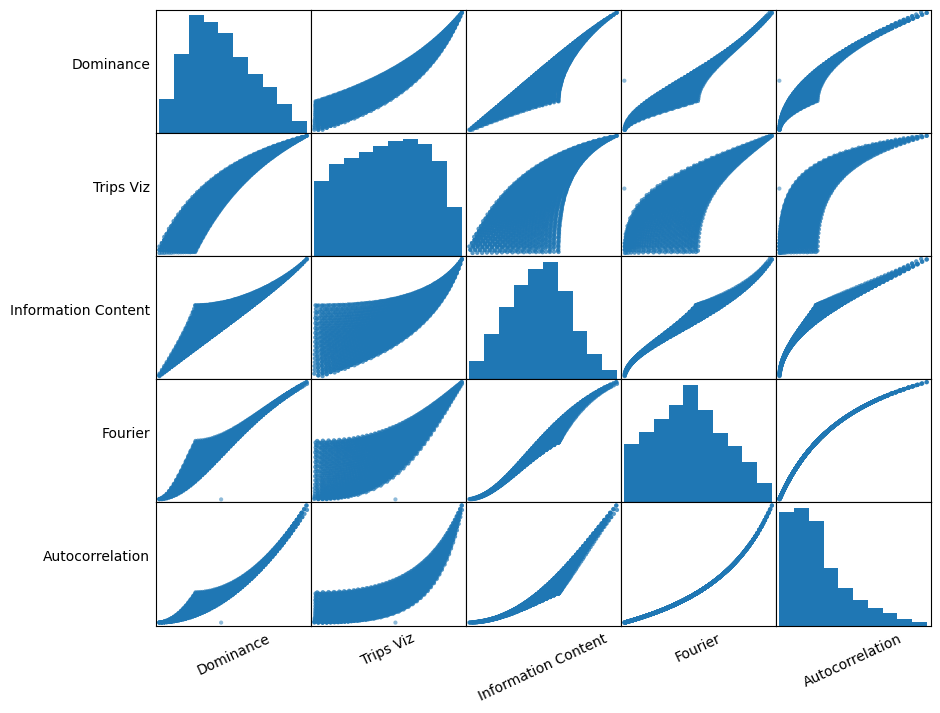

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

# scaler = MinMaxScaler()
scaler = MaxAbsScaler()

df = simulated_metrics[
    [
        'Dominance',
        'Trips Viz',
        'Information Content',
        'Fourier',
        'Autocorrelation',
        ]
        ]
# round all scores to 2 decimal palces
df['Dominance'].round(2)

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Create a scatter plot matrix
# Create a scatter plot matrix
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 8))
pd.plotting.scatter_matrix(df_scaled, ax=axes, alpha=0.5)

# Rotate the x-axis tick labels
for ax in axes.flatten():
    # turn off axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    ax.tick_params(axis='x', labelrotation=0)
    # set vmin and vmax for all subplots
    # ax.set_ylim([0, 1])
    # ax.set_xlim([0, 1])
    
    # rotate axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 25)
    ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = 'right')

# plt.savefig('Figures/periodicity_scatter_matrix.png', format='png')
plt.show()

Text(0.5, 1.0, 'Spearman Correlation')

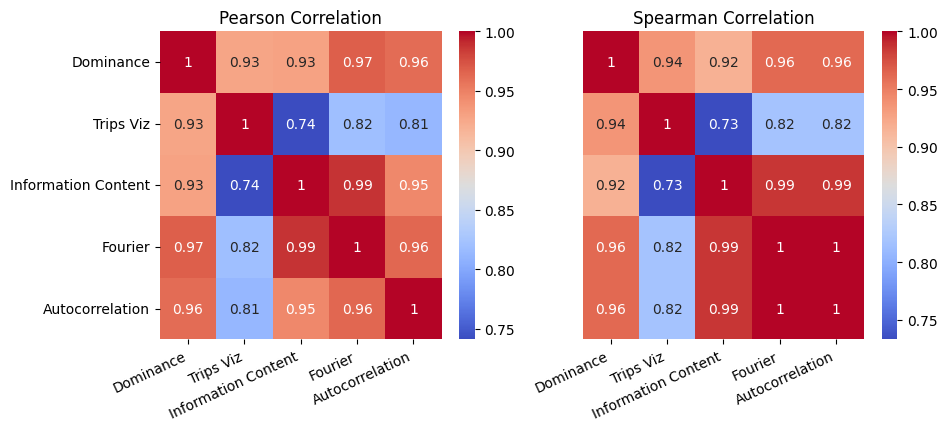

In [30]:
# plot correlation matrix for simulated metrics

import seaborn as sns

# Calculate the correlation matrix - Pearson correlation
corr_pearson = df.corr()
corr_spearman = df.corr(method='spearman')


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

# Create a heatmap for the Pearson correlation
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Pearson Correlation')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=25, horizontalalignment='right')

# Create a heatmap for the Spearman correlation
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=ax[1])
# turn off labels on y axis 
ax[1].set_yticks([])
#rotate x tick
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=25, horizontalalignment='right')
ax[1].set_title('Spearman Correlation')

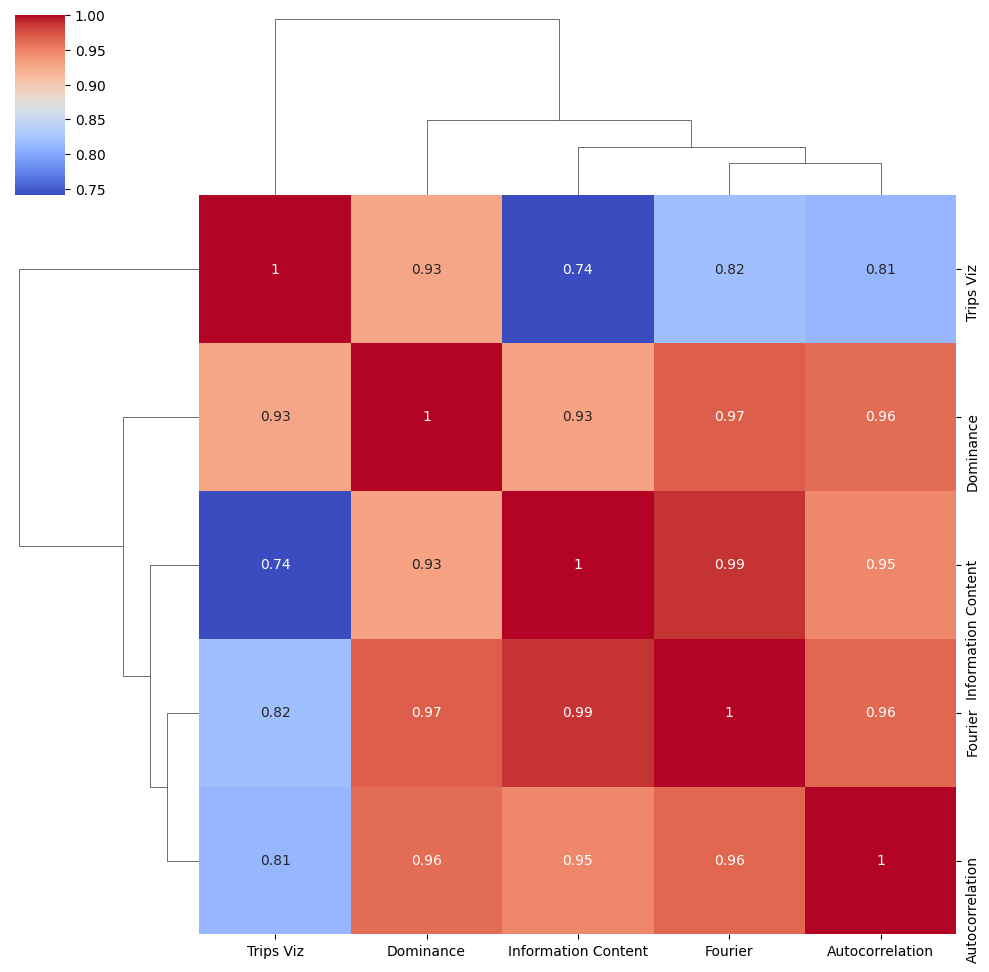

In [31]:
# cluster df of metrics by similarity
import seaborn as sns


#apply minMax scalar 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Calculate the correlation matrix
corr = df_scaled.corr()

# Create a heatmap of the correlation matrix
sns.clustermap(corr, annot=True, cmap='coolwarm') #, vmax=1, vmin=0) # ax=ax)


In [32]:
def plot_metrics(metrics, scaler=None, title='Metrics for Simulated Metagenes'):
    """
    Plot the metrics for the simulated metagenes.
    
    Args:
        metrics (pd.DataFrame): A DataFrame containing the metrics for the simulated metagenes.
        scaler (sklearn.preprocessing): A scaler object to scale the metrics.
    
    Returns:
        None
    """
    # Scale the metrics
    if scaler:
        metrics_scaled = pd.DataFrame(scaler.fit_transform(metrics), columns=metrics.columns)
    else:
        metrics_scaled = metrics
    
    # Create the figure
    fig = go.Figure()
    
    # Add traces for each metric
    for col in metrics_scaled.columns:
        fig.add_trace(go.Box(y=metrics_scaled[col], name=col))

    # Set the axis labels
    fig.update_layout(xaxis_title='Metagene', yaxis_title='Scaled Value', title=title)

    # Show the plot
    fig.show()

In [33]:

plot_metrics(df, scaler=MinMaxScaler(), title='Metrics for Simulated Metagenes (MinMax Scaler)')
plot_metrics(df, scaler=MaxAbsScaler(), title='Metrics for Simulated Metagenes (MaxAbs Scaler)')


In [34]:
# plot fourier value in histogram

fig = go.Figure(data=[go.Histogram(x=simulated_metrics['Fourier'])])

fig.show()

In [35]:
def plot_read_frame_proportions(metagene_profile, read_length, title='Read Frame Proportions'):
    """
    Plot the read frame proportions for a given read length.

    Args:
        metagene_profile (dict): The metagene profile dictionary.
        read_length (int): The read length to plot.
        title (str): The title of the plot.

    Returns:
        None
    """
    # Get the read frame proportions for the given read length
    read_frame_proportions = metagene_profile['start'][read_length]
    frame_counts = {0: 0, 1: 0, 2: 0}

    # Calculate the total count for each frame
    for pos, count in read_frame_proportions.items():
        frame = pos % 3
        frame_counts[frame] += count


    # Create the figure
    fig = go.Figure()

    fig.add_trace(go.Bar(x=list(frame_counts.keys()), y=list(frame_counts.values())))

    # Set the axis labels and title
    fig.update_layout(xaxis_title='Frame', yaxis_title='Proportion', title=title)

    # Show the plot
    fig.show()

# Plot the read frame proportions for a given read length
plot_read_frame_proportions(simulated_metagenes, 30, title='Read Frame Proportions for Read Length 30')

In [36]:
def plot_read_frame_proportions(read_frame_counts={0:47, 1:10, 2:43}, title='Read Frame Proportions'):
    """
    Plot the read frame proportions for a given read length.

    Args:
        read_frame_counts (dict): The read frame counts dictionary.
        title (str): The title of the plot.

    Returns:
        None
    """

    # Create the figure
    fig = go.Figure()

    fig.add_trace(go.Bar(x=list(read_frame_counts.keys()), y=list(read_frame_counts.values())))

    # Set the axis labels and title
    fig.update_layout(xaxis_title='Frame', yaxis_title='Proportion', title=title, width=600, height=400)

    # Show the plot
    fig.show()

# Plot the read frame proportions for a given read length
plot_read_frame_proportions()


In [37]:
# Create a dictionary of the metagenes to plot
metagenes = {
    'High/High': generate_metagene({0:89, 1:1, 2:10}, 10, 50),
    'High/Low': generate_metagene({0:47, 1:10, 2:43}, 10, 50),
    'Low/Low': generate_metagene({0:33, 1:34, 2:33}, 10, 50),
}

# Create a figure with three subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=('High Periodicity/High Frame Dominance', 'High Periodicity/Low Frame Dominance', 'Low Periodicity/Low Frame Dominance'))


# Plot each metagene in a separate subplot
for i, (metagene_name, metagene) in enumerate(metagenes.items(), start=1):
    positions = list(metagene.keys())
    counts = list(metagene.values())

    proportions = counts_to_codon_proportions(counts)[:-1]

    # make all blue
    fig.add_trace(go.Bar(x=positions, y=proportions, marker_color='blue'), row=1, col=i)

    # make y axis 0-1
    fig.update_yaxes(range=[0, 1], row=1, col=i)
    # turn off x & y axis ticks
    fig.update_xaxes(showticklabels=False, row=1, col=i) #, title_text='Position')
    fig.update_yaxes(showticklabels=True, row=1, col=i, title_text='Proportion Per Codon')

# remove legend
fig.update_layout(showlegend=False)

# Show the plot
fig.show()